In [100]:
import numpy as np
import pandas as pd

import os
from matplotlib import pyplot as plt

import klampt
from klampt.model import ik

world = klampt.WorldModel()
robot_path = "data/robots/pr2.rob"
robot_record_dir = "robot_records"
num_ik_solutions = 3000
num_subplots = 5
num_ticks = 5

In [101]:
robot_name = robot_path.split("/")[-1].split(".")[0]
world.loadElement(robot_path)

robot = world.robot(0)
robot.randomizeConfig()
lastLink = robot.link(robot.numLinks()-1)
link = lastLink
print(robot.getConfig())
R = link.getTransform()[0]
t = link.getTransform()[1]
obj = ik.objective(link, R=R, t=t)


ikSolutions = np.zeros((num_ik_solutions, robot.numLinks()))

i = 0
while i < num_ik_solutions:
    solved = ik.solve_global(
        obj,
        iters=1000,
        tol=1e-3,
        activeDofs=None,
        numRestarts=100,
        feasibilityCheck=None,
        startRandom=True,
    )
    if solved:
        ikSolutions[i] = robot.getConfig()
        i += 1
        
df = pd.DataFrame(ikSolutions)

# remove columns with std smaller than 1e-4
df = df.loc[:, df.std() > 1e-4]
num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
df.describe()

WorldModel::LoadRobot: data/robots/pr2.rob
[0.0, 0.0, 0.0, 0.0, 0.0, -0.9022032464946821, 0.0, 0.0, 0.0, 6.213957677115828, 5.130844630274143, 1.3076793458568525, 4.773793274925763, 3.9227522243394426, 5.520201280814208, 2.889723643808705, 4.5122813923443985, 6.262079202872939, 5.039348587008365, 1.0020866928053647, 5.069337322162092, 0.1920601286888403, 0.9084470473627779, 0.22795533095483272, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19048602452996022, 0.4582113740155527, 3.489859414421888, 0.0, -1.22565498739884, 2.782612506584316, 0.0, 0.0, 0.0, -1.1907589242564325, 1.1992821661258892, 0.0, 0.22101337073976798, 0.4610347774778655, 0.0, 0.0, 0.05939980743424958, 5.082996026514027, 0.5012358522234652, 0.20439843668434698, 0.0, 0.0, 0.0, 0.2609073335618143, 0.0, -1.5580194997852796, 0.17690504761575965, -1.7843993893751868, 0.0, -2.1842056706401545, 3.6001961584001045, 0.0, 0.0, 0.0, -1.7224

,0,1,2,3,4,5,99
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.144149,0.013755,-0.017672,-15.431458,0.131900,-0.038989,3.092191
std,0.079039,0.077733,0.098424,13.120819,0.736288,0.534102,2.256282
min,-0.300279,-0.094038,-0.118160,-40.709714,-0.902397,-0.902261,-2.413738
25%,-0.198230,-0.081182,-0.112448,-26.672334,-0.752101,-0.484565,0.832550
50%,-0.144125,0.051502,-0.065257,-13.726569,0.449354,-0.049681,3.070120
75%,-0.087619,0.088593,0.102369,-5.100429,0.846093,0.387642,5.333269
max,0.000162,0.093084,0.117871,10.851459,0.902829,0.902229,8.636812


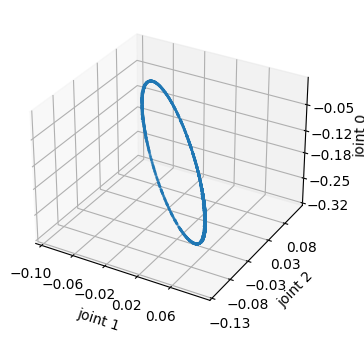

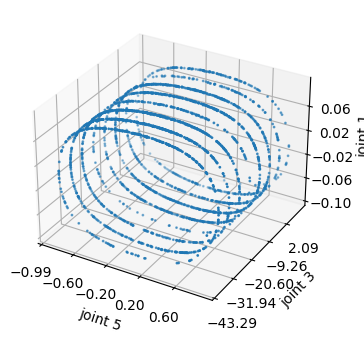

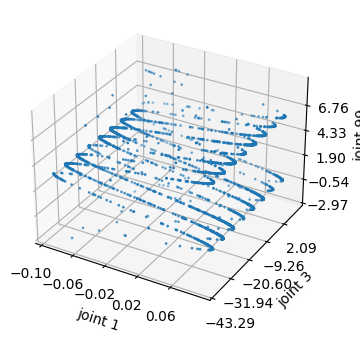

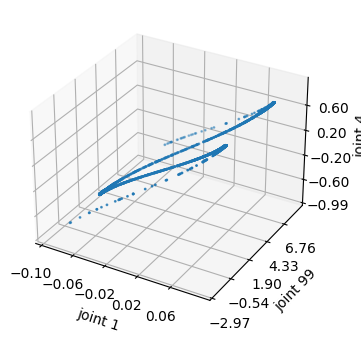

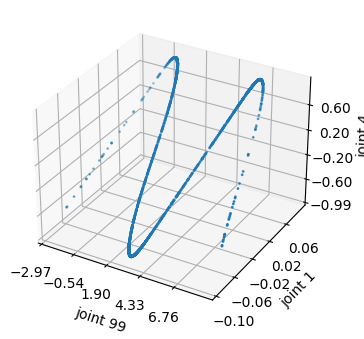

In [102]:

# generate 3 times random visualization
for i in range(num_subplots):
    fig = plt.figure(figsize=(4, 5))
    
    # random pick up 3 columns and sort them 
    columns = np.random.choice(df.columns, 3, replace=False)

    ax = fig.add_subplot(projection='3d')

    # plot data points by axis = these 3 columns
    ax.scatter(df[columns[0]], df[columns[1]], df[columns[2]], s=1)

    # set labels
    ax.set_xlabel(f"joint {columns[0]}")
    ax.set_ylabel(f"joint {columns[1]}")
    ax.set_zlabel(f"joint {columns[2]}")
    
    num_digits = 2
    start, end = ax.get_xlim()
    step = (end - start) / num_ticks
    ax.xaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))

    start, end = ax.get_ylim()
    step = (end - start) / num_ticks
    ax.yaxis.set_ticks(np.round(np.arange(start, end, step),num_digits))
    
    start, end = ax.get_zlim()
    step = (end - start) / num_ticks
    ax.zaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))
    
    # if not exist, create directory
    if not os.path.exists(f"{robot_record_dir}/{robot_name}"):
        os.makedirs(f"{robot_record_dir}/{robot_name}")
    
    # save figure by robot name and random number
    fig.savefig(f"{robot_record_dir}/{robot_name}/scatter_{i}.png")
